In [24]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import helper_libraries.results_tools as results_tools
import multiprocessing
import functools
import warnings
from tqdm.auto import tqdm

warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

## Returns and Spreads

In [27]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Trading

In [28]:
# Year to start trading
start_year = '2004'

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]

In [29]:
# Load model results
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    overnight=False,
    oos_periods=2,
    predictors="All",
    debug=True,
)

# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

Loading the following model results...
--------------------------------------------------
Folder           main
Overnight       False
OOSPeriods          2
Predictors        All
Notes            Done
Asset         ff__mkt
--------------------------------------------------


# Analysis

In [30]:
# Define data
trading_returns_df = oss_returns_all_df.copy()
predicted_returns_df = oss_retpred_all_df.copy()

In [31]:
# Plotting function
def plot_results(plot_df, fig, ax, y, ylabel, strategy, add_zero_line = True, use_percent_formatting = True):
    sns.lineplot(
        x="time",
        y=y,
        hue="model",
        palette="Set2",
        data=plot_df.reset_index(),
        ax = ax
    )
    sns.scatterplot(
        x="time",
        y=y,
        hue="model",
        palette="Set2",
        data=plot_df.reset_index(),
        legend=False,
        ax = ax
    )
    ax.set_title(strategy)
    ax.set_xlabel('Time')
    ax.set_ylabel(None)
    ax.grid(alpha = 0.1, axis = 'x')
    ax.get_legend().set_title('Model')
    
    if use_percent_formatting:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 2))

    if add_zero_line:
        ax.axhline(0, color = 'k', ls = '--', alpha = 0.5)
    
    if strategy != 'Market':
        ax.get_legend().remove()

## Average Returns

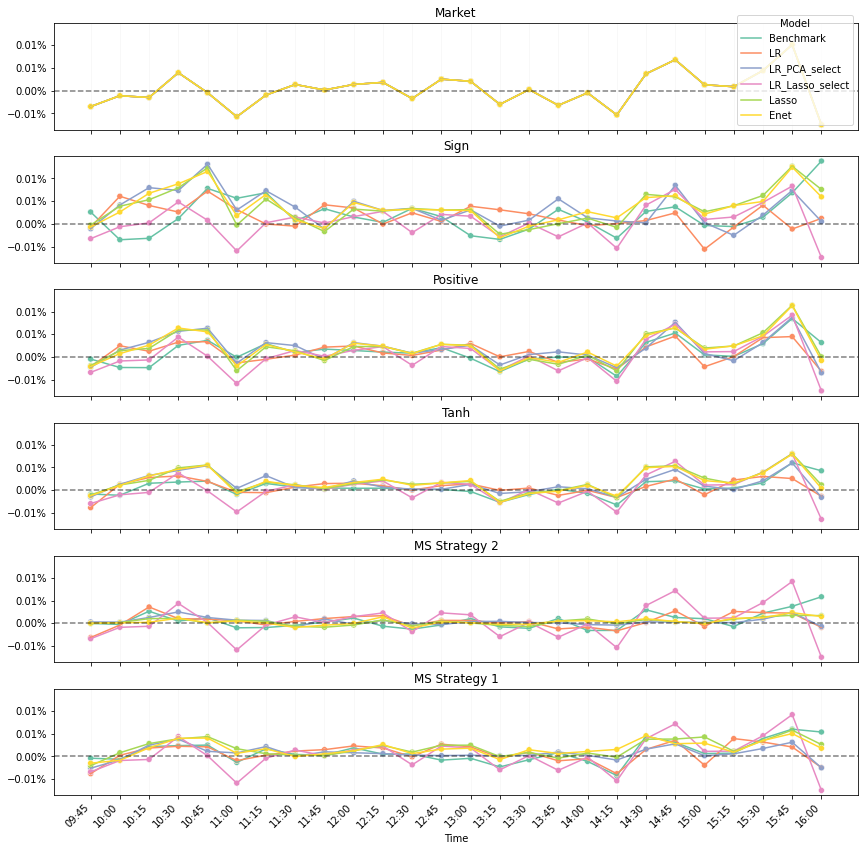

In [8]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 12), nrows = len(strategies_list), sharex=True, sharey=True)

for idx, strategy in enumerate(strategies_list):

    # Get returns for this strategy
    strategy_trading_returns_df = trading_returns_df.swaplevel(0, 1, axis=1)[strategy][model_list]

    # Aggregate to whatever frequency
    strategy_trading_returns_agg_df = strategy_trading_returns_df.groupby(
        pd.Grouper(freq="15min")
    ).sum()
    strategy_trading_returns_agg_df = strategy_trading_returns_agg_df.loc[
        list(set(strategy_trading_returns_df.index).intersection(strategy_trading_returns_agg_df.index))
    ]

    # Get returns by time
    strategy_trading_returns_agg_df["time"] = strategy_trading_returns_agg_df.index.strftime("%H:%M").astype(str)

    # Melt down for plotting
    strategy_trading_returns_agg_melt_df = (
        strategy_trading_returns_agg_df.groupby(["time"])
        .mean()
        .melt(ignore_index=False, var_name="model", value_name="average_return")
    )

    plot_results(strategy_trading_returns_agg_melt_df, fig, axs[idx], 'average_return', 'Average Return', strategy)
    
# Additional settings
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Save
filename = f"../../docs/exhibits/figures/diurnal_patterns_averagereturns.pdf"
fig.savefig(filename)

### For a few models

  0%|          | 0/4 [00:00<?, ?it/s]

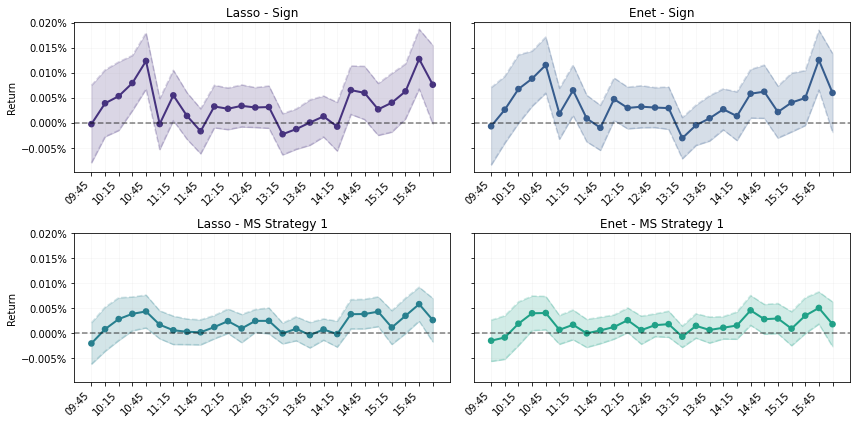

In [10]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, sharey=True)

model_strategy_pairs = [
    ("Lasso", "Sign"),
    ("Enet", "Sign"),
    ("Lasso", "MS Strategy 1"),
    ("Enet", "MS Strategy 1"),
]

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = trading_returns_df[model][strategy].to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    strategy_results_mean = strategy_results.set_index("time").groupby(level=0).mean()
    strategy_results_vol = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum().pipe(np.sqrt)
    ) / strategy_results.set_index("time").groupby(level=0).count()

    # Plot
    ax = axs.reshape(-1)[idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_mean.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    ax.fill_between(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
    )
    ax.plot(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
        ls = '--',
    )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title(pair_name, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=3))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.grid(alpha=0.1)

# Additional settings
plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/diurnal_patterns_winners_returns.pdf')

  0%|          | 0/4 [00:00<?, ?it/s]

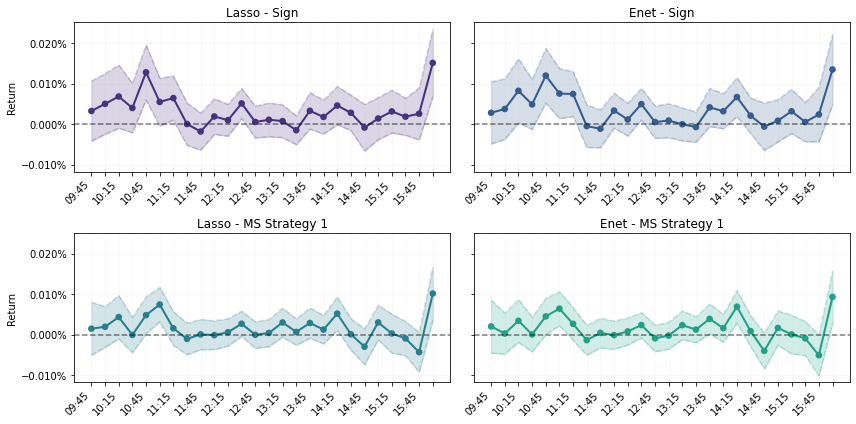

In [11]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, sharey=True)

model_strategy_pairs = [
    ("Lasso", "Sign"),
    ("Enet", "Sign"),
    ("Lasso", "MS Strategy 1"),
    ("Enet", "MS Strategy 1"),
]

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = trading_returns_df[model][strategy]
    strategy_results = strategy_results - trading_returns_df[model]['Market']
    strategy_results = strategy_results.to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    strategy_results_mean = strategy_results.set_index("time").groupby(level=0).mean()
    strategy_results_vol = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum().pipe(np.sqrt)
    ) / strategy_results.set_index("time").groupby(level=0).count()

    # Plot
    ax = axs.reshape(-1)[idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_mean.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    ax.fill_between(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
    )
    ax.plot(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
        ls = '--',
    )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title(pair_name, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=3))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.grid(alpha=0.1)

# Additional settings
plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/diurnal_patterns_winners_returns_minus_mkt.pdf')

## Average Vol

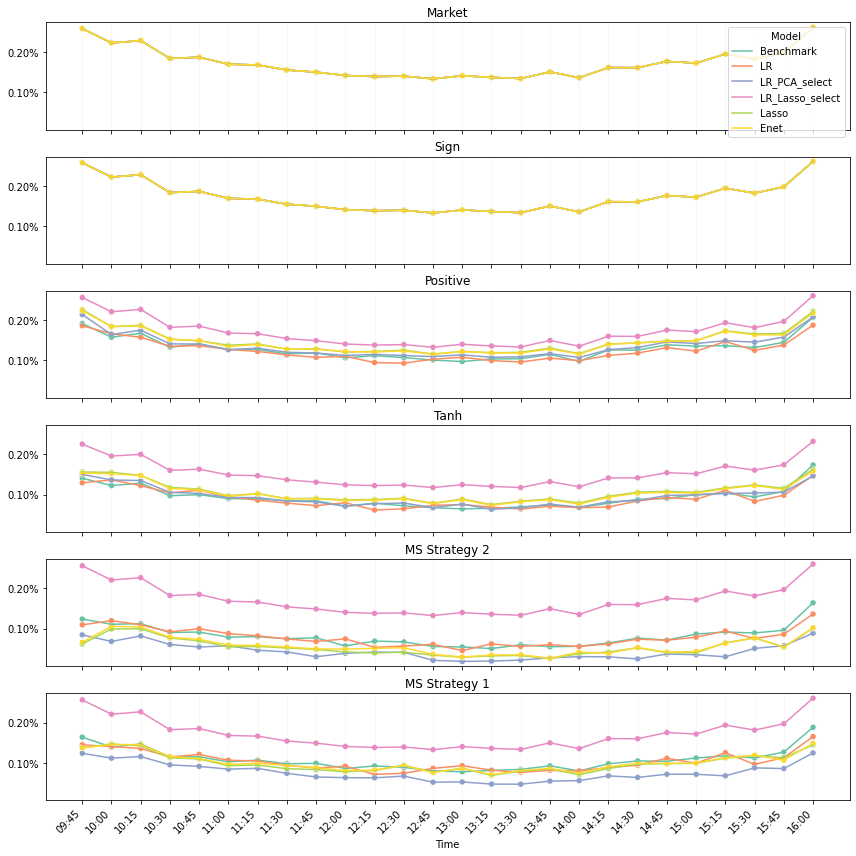

In [12]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 12), nrows = len(strategies_list), sharex=True, sharey=True)

for idx, strategy in enumerate(strategies_list):

    # Get returns for this strategy
    strategy_trading_returns_df = trading_returns_df.swaplevel(0, 1, axis=1)[strategy][model_list]

    # Aggregate to whatever frequency
    strategy_trading_returns_agg_df = strategy_trading_returns_df.groupby(
        pd.Grouper(freq="15min")
    ).sum()
    strategy_trading_returns_agg_df = strategy_trading_returns_agg_df.loc[
        list(set(strategy_trading_returns_df.index).intersection(strategy_trading_returns_agg_df.index))
    ]

    # Get returns by time
    strategy_trading_returns_agg_df = strategy_trading_returns_agg_df.pipe(np.square)
    strategy_trading_returns_agg_df["time"] = strategy_trading_returns_agg_df.index.strftime("%H:%M").astype(str)

    # Melt down for plotting
    strategy_trading_returns_agg_melt_df = (
        strategy_trading_returns_agg_df.groupby(["time"])
        .mean()
        .pipe(np.sqrt)
        .melt(ignore_index=False, var_name="model", value_name="average_rvol")
    )
    
    plot_results(strategy_trading_returns_agg_melt_df, fig, axs[idx], 'average_rvol', 'Average Volatility', strategy, add_zero_line = False)
    
# Additional settings
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Save
filename = f"../../docs/exhibits/figures/diurnal_patterns_rvol.pdf"
fig.savefig(filename)

## Sharpe

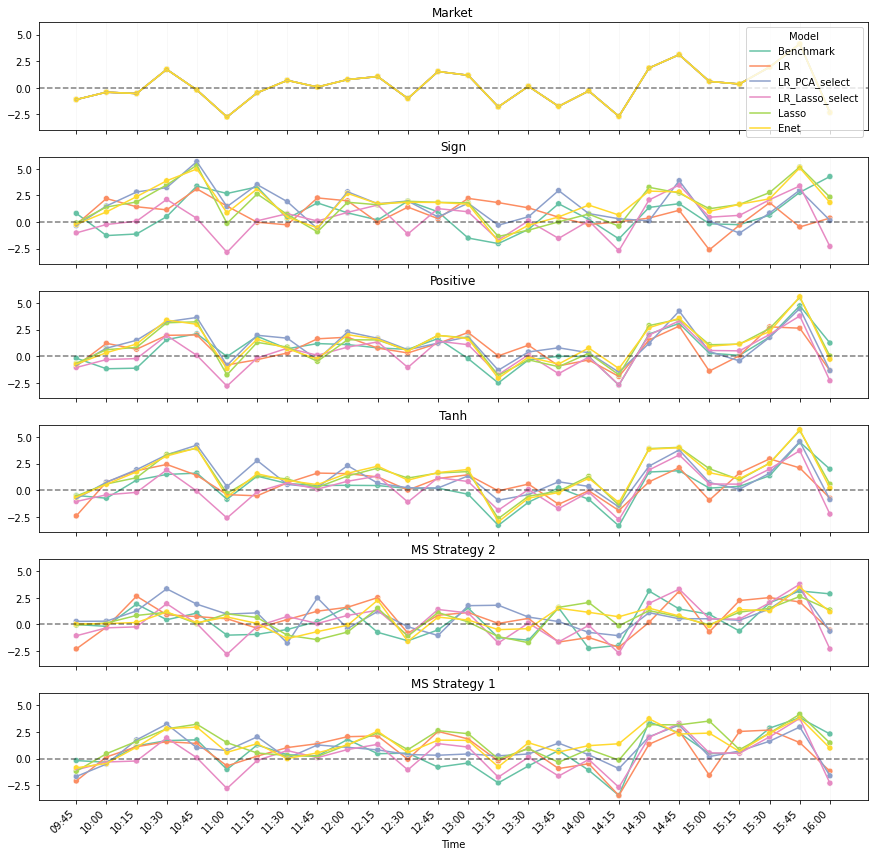

In [13]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 12), nrows = len(strategies_list), sharex=True, sharey=True)

for idx, strategy in enumerate(strategies_list):

    # Get returns for this strategy
    strategy_trading_returns_df = trading_returns_df.swaplevel(0, 1, axis=1)[strategy][
        model_list
    ]

    # Aggregate to whatever frequency
    strategy_trading_returns_agg_df = strategy_trading_returns_df.groupby(
        pd.Grouper(freq="15min")
    ).sum()
    strategy_trading_returns_agg_df = strategy_trading_returns_agg_df.loc[
        list(
            set(strategy_trading_returns_df.index).intersection(
                strategy_trading_returns_agg_df.index
            )
        )
    ]

    # Get average return
    strategy_trading_returns_agg_df[
        "time"
    ] = strategy_trading_returns_agg_df.index.strftime("%H:%M").astype(str)
    strategy_trading_returns_agg_melt_ret_df = (
        strategy_trading_returns_agg_df.groupby(["time"])
        .mean()
        .melt(ignore_index=False, var_name="model", value_name="average_ret")
    )

    # Get average volatility
    strategy_trading_returns_agg_df = strategy_trading_returns_agg_df.drop(
        ["time"], axis=1
    ).pipe(np.square)
    strategy_trading_returns_agg_df[
        "time"
    ] = strategy_trading_returns_agg_df.index.strftime("%H:%M").astype(str)
    strategy_trading_returns_agg_melt_vol_df = (
        strategy_trading_returns_agg_df.groupby(["time"])
        .mean()
        .pipe(np.sqrt)
        .melt(ignore_index=False, var_name="model", value_name="average_rvol")
    )

    # Get sharpe - note this is annualized
    strategy_trading_returns_agg_melt_sharpe_df = (
        strategy_trading_returns_agg_melt_ret_df
    )
    strategy_trading_returns_agg_melt_sharpe_df["sharpe"] = (
        strategy_trading_returns_agg_melt_ret_df["average_ret"]
        / strategy_trading_returns_agg_melt_vol_df["average_rvol"]
    ) * np.sqrt(len(np.unique(strategy_trading_returns_agg_melt_sharpe_df.index))*252)

    plot_results(strategy_trading_returns_agg_melt_sharpe_df, fig, axs[idx], 'sharpe', 'Sharpe', strategy, use_percent_formatting = False)
    
# Additional settings
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Save
filename = f"../../docs/exhibits/figures/diurnal_patterns_sharpe.pdf"
fig.savefig(filename)

### For a few models

In [14]:
def compute_sharpe(strategy_results):
    
    T = (strategy_results.index[-1] - strategy_results.index[0]).days/365
    strategy_results_sum = strategy_results.set_index("time").groupby(level=0).sum()
    strategy_results_var = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum()
    ) / T
    strategy_results_sharpe = (strategy_results_sum / T) / np.sqrt(strategy_results_var)
    
    return strategy_results_sharpe

  0%|          | 0/4 [00:00<?, ?it/s]

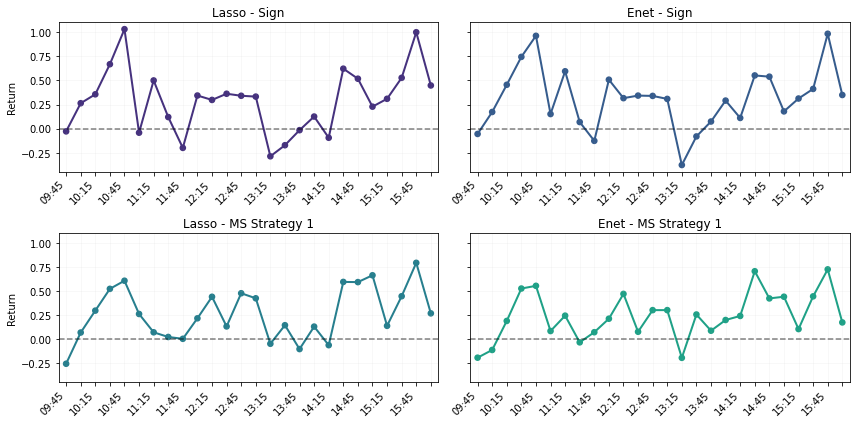

In [15]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, sharey=True)

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = trading_returns_df[model][strategy].to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    T = (strategy_results.index[-1] - strategy_results.index[0]).days / 365
    strategy_results_var = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum()
    ) / T
    strategy_results[pair_name] = strategy_results[pair_name].subtract(hrf_df['rf'])
    strategy_results_sum = strategy_results.set_index("time").groupby(level=0).sum()
    strategy_results_sharpe = (strategy_results_sum / T) / np.sqrt(strategy_results_var)

    # Plot
    ax = axs.reshape(-1)[idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_sharpe.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    # ax.fill_between(
    #     strategy_results_vol.index.values,
    #     (strategy_results_sharpe - strategy_results_std * 1.96).iloc[:, 0],
    #     (strategy_results_sharpe + strategy_results_std * 1.96).iloc[:, 0],
    #     color=color,
    #     alpha=0.2,
    # )
    # ax.plot(
    #     strategy_results_vol.index.values,
    #     (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
    #     (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
    #     color=color,
    #     alpha=0.2,
    #     ls = '--',
    # )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title(pair_name, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=2))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.grid(alpha=0.1)

# Additional settings
plt.tight_layout()
plt.savefig("../../docs/exhibits/figures/diurnal_patterns_winners_sharpe.pdf")

  0%|          | 0/4 [00:00<?, ?it/s]

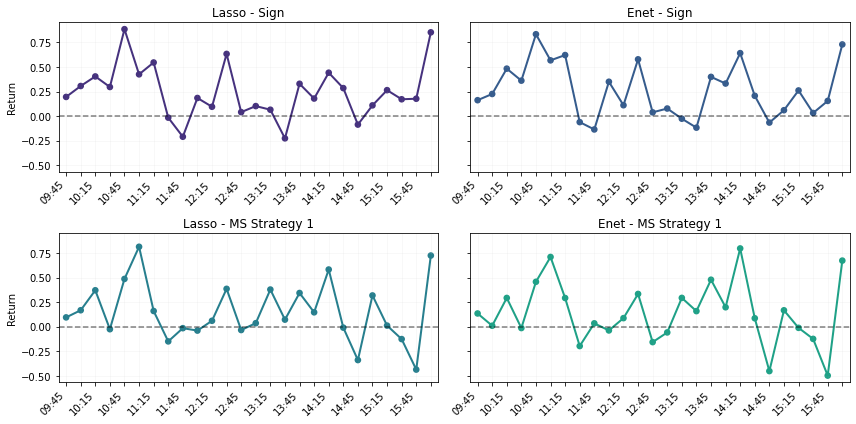

In [16]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, sharey=True)

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = trading_returns_df[model][strategy]
    strategy_results = strategy_results - trading_returns_df[model]['Market']
    strategy_results = strategy_results.to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    T = (strategy_results.index[-1] - strategy_results.index[0]).days / 365
    strategy_results_var = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum()
    ) / T
    strategy_results[pair_name] = strategy_results[pair_name].subtract(hrf_df['rf'])
    strategy_results_sum = strategy_results.set_index("time").groupby(level=0).sum()
    strategy_results_sharpe = (strategy_results_sum / T) / np.sqrt(strategy_results_var)

    # Plot
    ax = axs.reshape(-1)[idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_sharpe.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    # ax.fill_between(
    #     strategy_results_vol.index.values,
    #     (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
    #     (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
    #     color=color,
    #     alpha=0.2,
    # )
    # ax.plot(
    #     strategy_results_vol.index.values,
    #     (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
    #     (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
    #     color=color,
    #     alpha=0.2,
    #     ls = '--',
    # )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title(pair_name, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=2))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.grid(alpha=0.1)

# Additional settings
plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/diurnal_patterns_winners_sharpe_minus_mkt.pdf')

## Predicted Returns

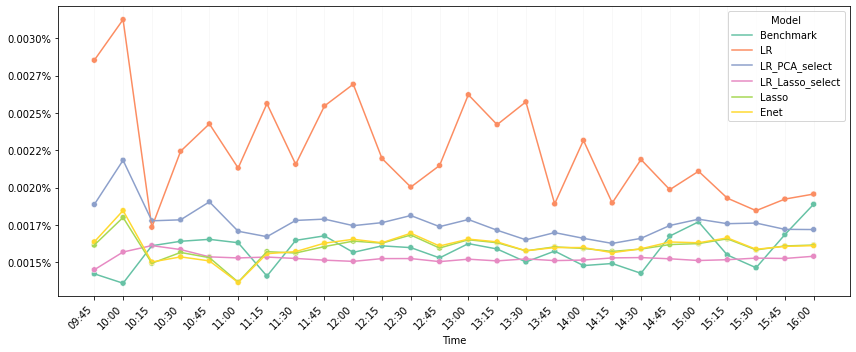

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))

# Get returns for this strategy
predicted_returns_fmt_df = predicted_returns_df

# Aggregate to whatever frequency
predicted_returns_fmt_agg_df = predicted_returns_fmt_df.groupby(
    pd.Grouper(freq="15min")
).sum()
predicted_returns_fmt_agg_df = predicted_returns_fmt_agg_df.loc[
    list(set(predicted_returns_fmt_df.index).intersection(predicted_returns_fmt_agg_df.index))
]

# Get returns by time
predicted_returns_fmt_agg_df["time"] = predicted_returns_fmt_agg_df.index.strftime("%H:%M").astype(str)

# Melt down for plotting
predicted_returns_fmt_agg_melt_df = (
    predicted_returns_fmt_agg_df.groupby(["time"])
    .mean()
    .melt(ignore_index=False, var_name="model", value_name="avg_pred")
)

# Plot
plot_results(predicted_returns_fmt_agg_melt_df, fig, ax, 'avg_pred', 'Average Prediction', '', add_zero_line = False)

# Additional settings
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals =4))
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.legend(title = 'Model')

fig.savefig(f"../../docs/exhibits/figures/diurnal_patterns_pred.pdf")

In [18]:
predicted_returns_fmt_agg_melt_df

,model,avg_pred
time,,
09:45,Benchmark,0.000014
10:00,Benchmark,0.000014
10:15,Benchmark,0.000016
10:30,Benchmark,0.000016
10:45,Benchmark,0.000017
...,...,...
15:00,Enet,0.000016
15:15,Enet,0.000017
15:30,Enet,0.000016


# Plots for main model/strat

In [32]:
plot_df = trading_returns_df.copy()
plot_df[('Enet', 'MS Strategy 1 (Difference)')] = plot_df['Enet']['MS Strategy 1'] - plot_df['Enet']['Market']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

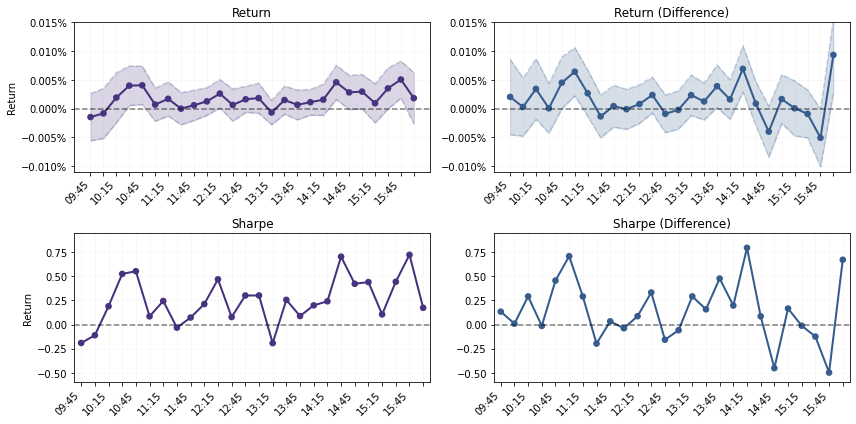

In [33]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, sharey=False)

model_strategy_pairs = [
    ("Enet", "MS Strategy 1"),
    ("Enet", "MS Strategy 1 (Difference)"),
]

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = plot_df[model][strategy].to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    strategy_results_mean = strategy_results.set_index("time").groupby(level=0).mean()
    strategy_results_vol = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum().pipe(np.sqrt)
    ) / strategy_results.set_index("time").groupby(level=0).count()

    # Plot
    ax = axs.reshape(-1)[idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_mean.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    ax.fill_between(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
    )
    ax.plot(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
        ls = '--',
    )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title('Return' if 'Difference' not in pair_name else 'Return (Difference)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=3))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.set_ylim(-0.00011, 0.00015)
    ax.grid(alpha=0.1)

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = plot_df[model][strategy].to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    T = (strategy_results.index[-1] - strategy_results.index[0]).days / 365
    strategy_results_var = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum()
    ) / T
    strategy_results[pair_name] = strategy_results[pair_name].subtract(hrf_df['rf'])
    strategy_results_sum = strategy_results.set_index("time").groupby(level=0).sum()
    strategy_results_sharpe = (strategy_results_sum / T) / np.sqrt(strategy_results_var)

    # Plot
    ax = axs.reshape(-1)[2+idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_sharpe.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title('Sharpe' if 'Difference' not in pair_name else 'Sharpe (Difference)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=2))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.set_ylim(-0.6, 0.95)
    ax.grid(alpha=0.1)   
    
# Additional settings
plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/diurnal_patterns_winner_returns_sharpe.pdf')

In [38]:
plot_df = oss_weights_all_df.copy()
plot_df[('Enet', 'MS Strategy 1 (Difference)')] = (plot_df['Enet']['MS Strategy 1'] - plot_df['Enet']['MS Strategy 1'].shift(1)).abs().fillna(0)

  0%|          | 0/2 [00:00<?, ?it/s]

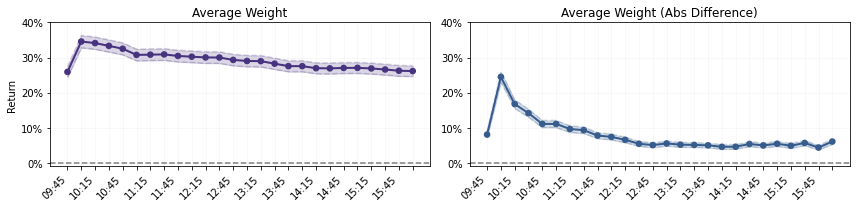

In [59]:
# Plot patterns for each strategy
fig, axs = plt.subplots(figsize=(12, 3), nrows=1, ncols=2, sharey=False)

model_strategy_pairs = [
    ("Enet", "MS Strategy 1"),
    ("Enet", "MS Strategy 1 (Difference)"),
]

for idx, model_strategy_pair in enumerate(tqdm(model_strategy_pairs)):

    # Get model/strat
    model, strategy = model_strategy_pair
    pair_name = f"{model} - {strategy}"

    # Get trading results
    strategy_results = plot_df[model][strategy].to_frame(pair_name).dropna()
    strategy_results["time"] = pd.Categorical(
        strategy_results.index.strftime("%H:%M").astype(str),
    )
    strategy_results_mean = strategy_results.set_index("time").groupby(level=0).mean()
    strategy_results_vol = (
        strategy_results.set_index("time").pipe(np.square).groupby(level=0).sum().pipe(np.sqrt)
    ) / strategy_results.set_index("time").groupby(level=0).count()

    # Plot
    ax = axs.reshape(-1)[idx]
    color = sns.color_palette("viridis", 6)[idx]
    sns.pointplot(
        x="time",
        y=pair_name,
        data=strategy_results_mean.reset_index(),
        ci=None,
        color=color,
        lw=2,
        ax=ax,
        scale=0.75,
    )
    ax.fill_between(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
    )
    ax.plot(
        strategy_results_vol.index.values,
        (strategy_results_mean - strategy_results_vol*1.96).iloc[:, 0],
        (strategy_results_mean + strategy_results_vol*1.96).iloc[:, 0],
        color=color,
        alpha=0.2,
        ls = '--',
    )

    ax.axhline(0, color="k", ls="--", alpha=0.5)
    ax.set_title('Average Weight' + (' (Abs Difference)' if 'Difference' in pair_name else ''), fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if idx % 2 == 0:
        ax.set_ylabel("Return")
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    [l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
    ax.set_ylim(-0.01, 0.4)
    ax.grid(alpha=0.1)
    
# Additional settings
plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/diurnal_patterns_winner_weights.pdf')